In [1]:
import xarray as xr
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics import R2Score
from torch.optim  import  lr_scheduler
from einops import rearrange
import matplotlib.pyplot as plt
import pandas as pd

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [2]:

# self defined func
from data_process_v2 import norm_mean_std, create_train_test_dataset_selectout, ClimSimDataset
from train_util_new import min_max_clip, test, train, save_submit_nc_sel
from test_util  import test_model_ensemble, test_model_ensemble_rm_maxmin, test_model_ensemble_R2weighted, save_ens_csv, create_submit_output_ens

batch_size =  5000
submit = True
model_name = 'bagging'

data_source, test_size = 'large', 0.15 # or small for quick test
data_source, test_size = 'test', 0.99 # or small for quick test

# R_crit = 0.65 # threshold to save output 
# T_0 = 10 # CosineAnnealingWarmRestarts
# epochs = 4*T_0 # total epoch NxT_0 N = 1,2,3,4

##########################################################################################################
# output_selection
##########################################################################################################
output_mask = np.ones(368)
output_mask[132:148] = 0 # remove q0002 132-147

##########################################################################################################
# load data
########################################################################################################## 
if submit:
    train_dataset, test_dataset, output_mask, input_offset, input_scale, output_offset, output_scale, submit_input, output_selection, output_name \
    = create_train_test_dataset_selectout(dataset = data_source, norm='std', test_size=test_size, output_selection = output_mask, submit=submit)
    # submit data
    submit_dataloader = DataLoader(submit_input, batch_size=batch_size, shuffle=False)
else:
    train_dataset, test_dataset, output_mask, input_offset, input_scale, output_offset, output_scale, output_selection, output_name \
    = create_train_test_dataset_selectout(dataset = data_source, norm='std', test_size=test_size, output_selection = output_mask, submit=submit)


output_min = torch.tensor(train_dataset.output.min(axis=0))
output_max = torch.tensor(train_dataset.output.max(axis=0))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)
input_dim = input_offset.size
output_dim = output_offset.size 

root = '/tigress/cw55/work/2024_leap_climsim'
data_name = list(pd.read_csv(f'{root}/data/sample_submission.csv').columns[1:])

Removed fixed input. Now the number of the input feature is  (490,)
Removed fixed input. Now the number of the output feature is (292,)
train sample size: 15137
test sample size: 1498591


# load model

In [3]:
from FNN_baseline_v1_sel import FNN, ln_block
from Unet2d_baseline_v1 import Unet2d, CNN_block
from Transformer import Transformer, MLP, MSA,PatchEmbedding_PosiEmbedding,Trans_Block
loss_fn = nn.MSELoss()

In [4]:
# set model path 
R2_ckpt_path = {
    # 'FNN1':          '../results/FNN_v2_all_outi_0_e40_r2all_0.704_r2sel_0.628',
    # 'FNN2':          '../results/FNN_v2_all_outi_0_e20_r2all_0.705_r2sel_0.628',
    # 'Unet2d11':       '../results/Unet2D_k5_v2_all_outi_0_e10_r2all_0.718_r2sel_0.645',
    # 'Unet2d12':       '../results/Unet2D_k5_v2_all_outi_0_e20_r2all_0.724_r2sel_0.652',
    # 'Unet2d13':       '../results/Unet2D_k5_v2_all_outi_0_e40_r2all_0.725_r2sel_0.653',
    # # 'Unet2d21':       '../results/Unet2D_k5_v21_all_outi_0_e10_r2all_0.715_r2sel_0.641',
    # 'Unet2d22':       '../results/Unet2D_k5_v21_all_outi_0_e20_r2all_0.723_r2sel_0.651',
    # 'Unet2d23':       '../results/Unet2D_k5_v21_all_outi_0_e40_r2all_0.725_r2sel_0.653',
    # 'Transformer11':  '../results/Trans_1018_big360_v1_outi_0_e10_r2all_0.722_r2sel_0.650',
    'Transformer12':  '../results/Trans_1018_big360_v1_outi_0_e20_r2all_0.733_r2sel_0.664',
    'Transformer13':  '../results/Trans_1018_big360_v1_outi_0_e40_r2all_0.737_r2sel_0.668',
    # 'Transformer21':  '../results/Trans_1018_big360_v2_outi_0_e10_r2all_0.725_r2sel_0.654',
    'Transformer22':  '../results/Trans_1018_big360_v2_outi_0_e20_r2all_0.735_r2sel_0.666',
    'Transformer23':  '../results/Trans_1018_big360_v2_outi_0_e30_r2all_0.739_r2sel_0.671',
    'Transformer24':  '../results/Trans_1018_big360_v2_outi_0_e40_r2all_0.739_r2sel_0.671',
    # 'Transformer31':  '../results/Trans_1018_big360_v22_outi_0_e10_r2all_0.725_r2sel_0.653',
    'Transformer32':  '../results/Trans_1018_big360_v22_outi_0_e20_r2all_0.735_r2sel_0.667',
    'Transformer33':  '../results/Trans_1018_big360_v22_outi_0_e30_r2all_0.738_r2sel_0.670',
    'Transformer34':  '../results/Trans_1018_big360_v22_outi_0_e40_r2all_0.739_r2sel_0.671',
    # 'Transformer41':  '../results/Trans_1018_big360_v23_outi_0_e10_r2all_0.722_r2sel_0.650',
    'Transformer42':  '../results/Trans_1018_big360_v23_outi_0_e20_r2all_0.732_r2sel_0.663',
    'Transformer43':  '../results/Trans_1018_big360_v23_outi_0_e30_r2all_0.735_r2sel_0.666',
    'Transformer44':  '../results/Trans_1018_big360_v23_outi_0_e40_r2all_0.736_r2sel_0.667',
} 
model_list = { } 
# load saved model
for name in R2_ckpt_path:
    print(name)
    PATH = R2_ckpt_path[name]
    model = torch.load(f'{PATH}.ckpt')
    model.eval()
    model_list[name] = model

Transformer12
Transformer13
Transformer22
Transformer23
Transformer24
Transformer32
Transformer33
Transformer34
Transformer42
Transformer43
Transformer44


Transformer12
Transformer13
Transformer22
Transformer23
Transformer24
Transformer32
Transformer33
Transformer34
Transformer42
Transformer43
Transformer44
R_ALL: 0.7331897054353486
R_ALL: 0.7368478290736675
R_ALL: 0.7351213826433473
R_ALL: 0.7386779862901439
R_ALL: 0.7391180025170678
R_ALL: 0.7354867064758487
R_ALL: 0.7381969293498475
R_ALL: 0.7388212481594604
R_ALL: 0.7322860164162905
R_ALL: 0.7350280579665432
R_ALL: 0.7358474997074708
R2_max_merge 0.7477945886228395


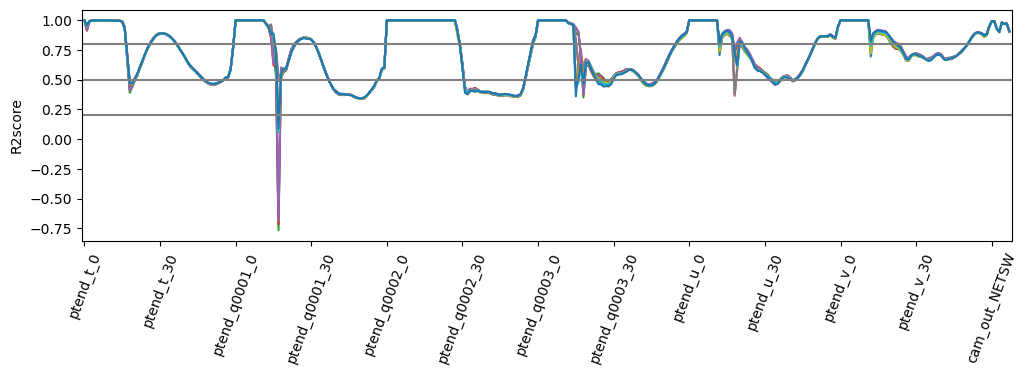

In [5]:
R2value_list = [] 
loss_test = []
for name in model_list:
    print(name)
    model = model_list[name]
    # l_test, R2value = test(test_dataloader, model, loss_fn, output_mask, device, output_selection=output_selection)
    R2value = np.ones(368)
    R2value[output_selection] = xr.open_dataset(f'{R2_ckpt_path[name]}.nc').R2.values
    R2value_list.append(R2value) 
    # loss_test.append(l_test)

plt.subplots(figsize=(12, 3))
# for R2value in R2_list+[R2_cnn]+[R2_fnn]:
for R2value in R2value_list:
    plt.plot(R2value) 
    print(f'R_ALL: {R2value.mean()}')
plt.plot([0,368],[0.8,0.8],c='grey')
plt.plot([0,368],[0.5,0.5],c='grey')
plt.plot([0,368],[0.2,0.2],c='grey')
# plt.ylim(0,1.01)
plt.xlim(-1,368)
plt.ylabel('R2score')
plt.xticks(np.arange(len(data_name))[::30],data_name[::30],rotation=70) 
R2_merge = np.array(R2value_list).max(axis=0) # select the max R2 to merge
print('R2_max_merge',np.mean(R2_merge))
plt.show()

# model weighted mean

In [6]:
R2value_list = np.array(R2value_list)
R2order = R2value_list.argsort(axis=0)
R2ranks = R2order.argsort(axis=0)+1
R2ranks = R2ranks[:,None,:] # model x 1 x feature
 
l_test, R2value = test_model_ensemble_R2weighted(test_dataloader, model_list, R2ranks, loss_fn, output_mask, device,  output_selection )

100%|██████████| 300/300 [15:20<00:00,  3.07s/it]

Test Error:  Avg loss: 0.28302 R2score_sele: 0.717 
 R2score(R=1 for mask=0): 0.775  


In [7]:
output = create_submit_output_ens(model_list, R2ranks, submit_dataloader, device, output_selection)

100%|██████████| 125/125 [06:27<00:00,  3.10s/it]


In [8]:
save_ens_csv(output, 'ens_v3_11Trans', model_list, R2ranks, output_scale, output_offset, submit_dataloader, R2value, device, output_selection)

Submission file saved! /tigress/cw55/work/2024_leap_climsim/results/ens_v3_11Trans_r2all_0.775_r2sel_0.717.csv


,sample_id,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,...,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
0,test_0,0.00001,-0.00006,-0.000082,-0.000084,-0.000094,-0.000097,-0.000078,-0.000062,-0.000048,...,0.000006,0.000001,-6.286897,394.189043,-0.0,0.0,-2.433257,-2.358699,-1.518211,-1.297657
1,test_10,0.00001,-0.00005,-0.000034,-0.000051,-0.000089,-0.00013,-0.000134,-0.000094,-0.000045,...,0.000001,0.000005,1.947341,336.878606,-0.0,0.0,1.542772,-0.242081,-0.981427,0.282931
2,test_100,0.00001,-0.000078,-0.000035,-0.000029,-0.000075,-0.000095,-0.000079,-0.000055,-0.000031,...,0.000003,0.000011,1.296745,330.32285,-0.0,0.0,0.672102,-0.330691,1.31557,1.311186
3,test_1000,0.00001,0.000007,0.000033,0.000027,-0.000005,-0.000056,-0.000049,-0.000021,-0.000007,...,-0.000038,0.000022,-3.322423,353.160301,-0.0,0.0,-8.362812,-1.099747,3.974423,-0.304933
4,test_10000,0.00001,0.000029,0.000046,0.000085,0.000124,0.000171,0.000187,0.000147,0.000088,...,0.000001,-0.000004,891.299058,377.187765,0.0,0.0,419.643633,425.335761,57.608128,10.787381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624995,test_99994,0.00001,-0.000013,0.000018,0.000096,0.000129,0.00016,0.000138,0.000102,0.000066,...,0.000003,0.000005,407.319329,399.466443,-0.0,0.0,174.815299,183.886051,64.096847,26.739245
624996,test_99995,0.00001,-0.000064,-0.000144,-0.000076,-0.000066,-0.000056,-0.000046,-0.000038,-0.00003,...,0.000002,-0.000006,0.824082,128.33934,0.0,0.0,0.459417,1.105598,-0.811496,-0.961439
624997,test_99996,0.00001,0.000007,0.000015,0.000023,0.00004,0.000055,0.000049,0.000035,0.00002,...,-0.0,0.0,70.796796,178.883237,0.0,0.0,106.672029,157.035403,64.974355,20.769597
624998,test_99997,0.00001,-0.000015,-0.000035,-0.000054,-0.00008,-0.000108,-0.000097,-0.000068,-0.000044,...,-0.000001,-0.000011,-8.388816,370.470949,-0.0,-0.0,-2.090665,-1.167471,0.374543,-0.075697


In [9]:
output.shape

(625000, 292)

R_ALL: 0.7754222112505332
R2_max_merge 0.7477945886228395


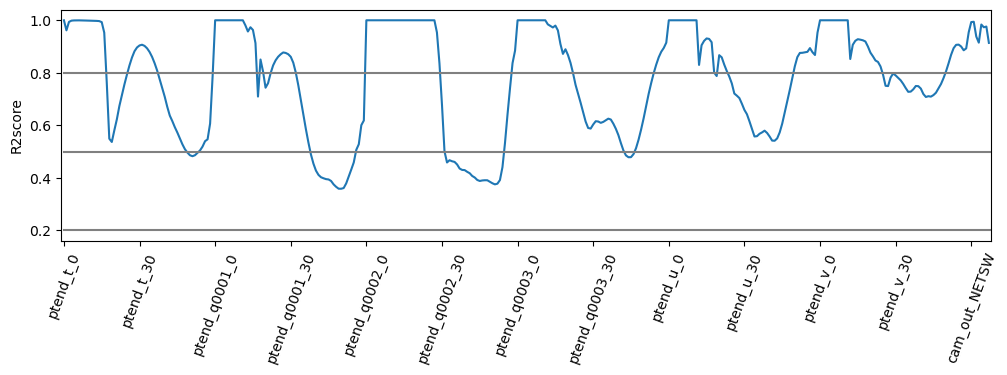

In [10]:
plt.subplots(figsize=(12, 3))
# for R2value in R2_list+[R2_cnn]+[R2_fnn]:
# for R2value in R2value_list:
plt.plot(R2value) 
print(f'R_ALL: {R2value.mean()}')
plt.plot([0,368],[0.8,0.8],c='grey')
plt.plot([0,368],[0.5,0.5],c='grey')
plt.plot([0,368],[0.2,0.2],c='grey')
# plt.ylim(0,1.01)
plt.xlim(-1,368)
plt.ylabel('R2score')
plt.xticks(np.arange(len(data_name))[::30],data_name[::30],rotation=70) 
R2_merge = np.array(R2value_list).max(axis=0) # select the max R2 to merge
print('R2_max_merge',np.mean(R2_merge))
plt.show()